# Example With Tenserflow - Sequence Model

# imports

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import functools

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models

/home/sogol/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sogol/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sogol/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sogol/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

## Read Data Test and Train dataset

In [8]:
LABEL_COLUMN = 'Pos'
file_pattern = '../data/preprocessed/refine.csv'
batch_size = 10
SELECT_COLUMNS = ['RSSI1', 'RSSI2', 'RSSI3', 'Lux', 'Acc_x', 'Acc_y','Acc_z','Temp','Pos']
number_feature_col =8
all_dataset = tf.data.experimental.make_csv_dataset(
    file_pattern,
    1,
    label_name=LABEL_COLUMN,
    select_columns = SELECT_COLUMNS,
    na_value='?',
    header=True,
    num_epochs=1,
    ignore_errors=True
)

# Make Test And Traing

In [9]:
test_dataset = all_dataset.take(1000) 
test_dataset = test_dataset.batch(batch_size)

def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels
  
features, labels = next(iter(test_dataset))
test_dataset = test_dataset.map(pack_features_vector)
features, labels = next(iter(test_dataset))

train_dataset = all_dataset.skip(1000)
train_dataset = train_dataset.batch(batch_size)
features, labels = next(iter(train_dataset))



train_dataset = train_dataset.map(pack_features_vector)
features, labels = next(iter(train_dataset))

features = tf.cast( features, tf.float32,  name='Cast feature')
features = tf.reshape(features ,[-1, number_feature_col] )
labels = tf.reshape(labels ,[-1] )

# Create Model

In [20]:
model = models.Sequential()
model.add(layers.Conv1D(number_feature_col, 3, activation='relu', input_shape=( number_feature_col,1)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64,3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, 0, activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='softmax'))

model.summary()



ValueError: Negative dimension size caused by subtracting 2 from 1 for 'max_pooling1d_14/MaxPool' (op: 'MaxPool') with input shapes: [?,1,1,64].

In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset)

ValueError: Error when checking input: expected conv1d_15_input to have shape (10, 8) but got array with shape (8, 1)

In [57]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)


l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))

Loss test: 5.761009216308594


In [45]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [58]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))

Step: 0, Initial Loss: 5.761009216308594
Step: 1,         Loss: 5.752677917480469


In [59]:
## Note: Rerunning this cell uses the same model variables
# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 2

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
    for x, y in train_dataset:
        x = tf.cast( x, tf.float32,  name='x feature')
        x = tf.reshape(x ,[-1, number_feature_col] )
        y = tf.reshape(y ,[-1] )
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        epoch_accuracy(y, model(x, training=True))

# End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    # if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
                                                                

Epoch 000: Loss: 2.069, Accuracy: 56.371%
Epoch 001: Loss: 0.744, Accuracy: 86.862%


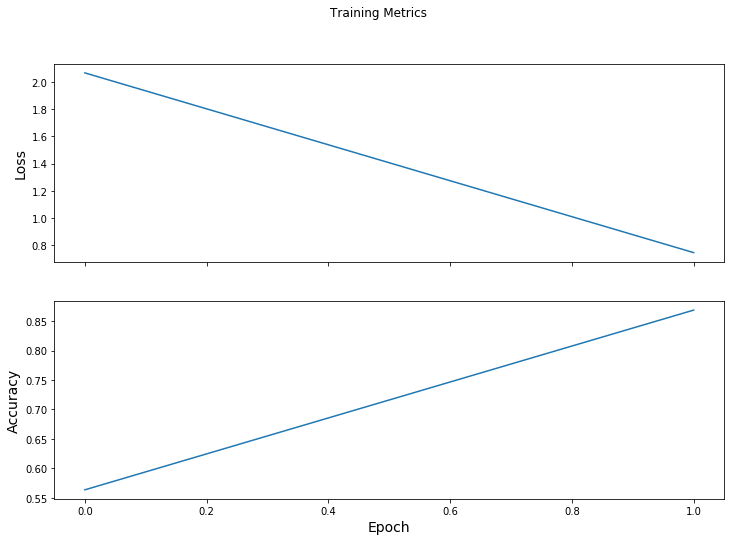

In [60]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [61]:
epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
for x, y in test_dataset:
    x = tf.cast( x, tf.float32,  name='x feature')
    x = tf.reshape(x ,[-1, number_feature_col] )
    y = tf.reshape(y ,[-1] )
    loss_value, grads = grad(model, x, y)
    # optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy(y, model(x, training=False))
print("Test Result: Loss: {:.3f}, Accuracy: {:.3%}".format( epoch_loss_avg.result(), epoch_accuracy.result()))    

Test Result: Loss: 0.849, Accuracy: 78.300%
